# FLAG multipulses

1 . ELOWRES vs ReconCalibEnergy   
    Set the dependency of the ELOWRES estimator with the reconstructed energy: draw ellipses    
2. 
   

In [154]:
import ipywidgets as widgets 
%matplotlib widget

import os
import glob
from subprocess import run, PIPE, STDOUT

from astropy.io import fits

import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt

from flag_multipulse import get_max_photons, get_polyfit_intervals_columns


In [155]:
def vprint(*args, **kwargs):
    """
    Print function that can be turned on/off with the verbose variable.
    """
    if verbose > 0:
        print(*args, **kwargs)

In [156]:
# read xifusim simulated files
datadir="/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/CEASaclay/October2024"
simfiles = glob.glob(f"{datadir}/mono*keV_5000p_50x30.fits")
invalid_samples = 1563
HR_oflen = 8192 #filter used for HR
verbose = 1
simEnergies = (0.2, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0)
nsigmas = 5 # for confidence interval polyfit

In [157]:
# reconstruct simulated files with SIRENA
lib_sirena = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/CEASaclay/October2024/optimal_filters_6keV_50x30.fits"
assert os.path.exists(lib_sirena), f"{lib_sirena} does not exist"
xml_xifusim = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/CEASaclay/October2024/config_xifu_50x30_v3_20240917.xml"
assert os.path.exists(xml_xifusim), f"{xml_xifusim} does not exist"
for xifusimfile in simfiles:
    assert os.path.exists(xifusimfile), f"{xifusimfile} does not exist"
    # remove path from filename:
    filename = os.path.basename(xifusimfile)
    # get energy value from xifusim file name
    energy = float(filename.split("_")[0].replace("keV", "").replace("mono", ""))
    reconsfile = f"singles/events_mono{energy}keV_5000p_50x30_of{HR_oflen}.fits"
    if not os.path.exists(reconsfile):
        comm = (f"tesrecons Recordfile={xifusimfile} "
            f" TesEventFile={reconsfile}"
            f" LibraryFile={lib_sirena}"
            f" XMLFile={xml_xifusim}"
            f" clobber=yes"
            f" EnergyMethod=OPTFILT"
            f" OFStrategy=BYGRADE"
            f" filtEeV=6000"
            f" OFNoise=NSD"
        )
        vprint(f"Doing reconstruction for xifusim file {xifusimfile}")
        vprint(f"Running {comm}")
        
        output_tesrecons = run(comm, shell=True, capture_output=True, cwd='/dataj6/ceballos/INSTRUMEN/EURECA/TN350_detection/2024_revision/')
        assert output_tesrecons.returncode == 0, f"tesrecons failed to run => {output_tesrecons.stderr.decode()}"
        assert os.path.exists(reconsfile), f"tesrecons did not produce an output file"
    else:
        vprint(f"Reconstructed file {reconsfile} already exists")
reconsfiles = glob.glob(f"singles/events_mono*keV_5000p_50x30_of8192.fits")
max_photons = get_max_photons(reconsfiles)        

Reconstructed file singles/events_mono7.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file singles/events_mono5.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file singles/events_mono10.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file singles/events_mono9.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file singles/events_mono3.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file singles/events_mono4.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file singles/events_mono0.5keV_5000p_50x30_of8192.fits already exists
Reconstructed file singles/events_mono8.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file singles/events_mono1.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file singles/events_mono12.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file singles/events_mono2.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file singles/events_mono11.0keV_5000p_50x30_of8192.fits alre

In [158]:

# create numpy arrays to store the data
# the first dimension is the energy, the second dimension is the number of photons  
# inititalize the arrays with NaN
SIGNAL = np.full((len(simEnergies), max_photons), np.nan)
ELOWRES = np.full((len(simEnergies), max_photons), np.nan)
AVG4SD = np.full((len(simEnergies), max_photons), np.nan)
medianSIGNAL = np.full((len(simEnergies)), np.nan)
medianELOWRES = np.full((len(simEnergies)), np.nan)
stdELOWRES = np.full((len(simEnergies)), np.nan)

for ie in range(len(simEnergies)):
    simE = simEnergies[ie]
    simfile = f"{datadir}/events_mono{simE}keV_5000p_50x30_of8192.fits"
    #print(f"Reading {simfile}")
    f = fits.open(simfile)
    # read the data and store 
    # store the array in the SIGNAL column in the second dimension of the SIGNAL array
    signal_data = f[1].data['SIGNAL']
    elow_data = f[1].data['ELOWRES']
    avg4sd_data = f[1].data['AVG4SD']
    SIGNAL[ie, :len(signal_data)] = signal_data
    ELOWRES[ie, :len(elow_data)] = elow_data
    AVG4SD[ie, :len(avg4sd_data)] = avg4sd_data
    medianSIGNAL[ie] = np.nanmedian(signal_data)
    medianELOWRES[ie] = np.nanmedian(elow_data)
    stdELOWRES[ie] = np.nanstd(elow_data)
    f.close()


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

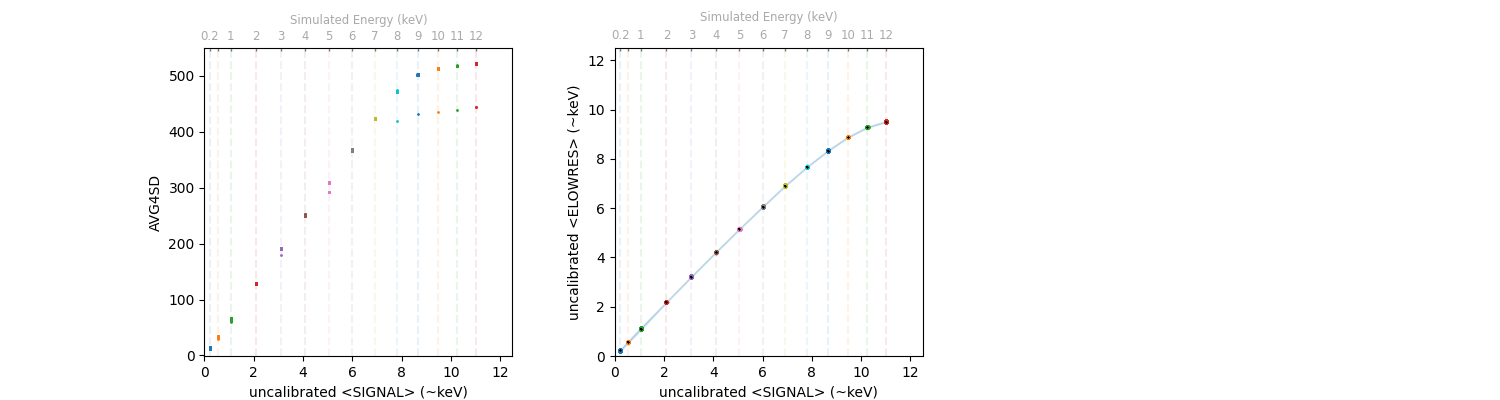

In [161]:
fig = plt.figure(figsize=(15,4))
#fig.suptitle("Pile-up markers analysis: xifusim-simulated Single pulses")
# do not use decimal points for values > 1 keV in the tick labels
simEnergies_lab = np.array(simEnergies, dtype='str')
for ie in range(len(simEnergies)):
    if simEnergies[ie] >= 1:
        simEnergies_lab[ie] = int(simEnergies[ie])

# ========================
# PLOT 1: AVG4SD vs SIGNAL
# ========================
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_xlim(0, 12.5)
ax1.set_ylim(-1, 550)
ytop = ax1.get_ylim()[1] 
ax1.set_ylabel("AVG4SD")
ax1.set_xlabel("uncalibrated <SIGNAL> (~keV)")
ax1.set_box_aspect(1)
# add a top title for the energy values
ax1.text(0.5*ax1.get_xlim()[1], ytop+50, "Simulated Energy (keV)", ha='center', va='center', fontsize='small', color="darkgray")

for ie in range(len(simEnergies)):
    simE = simEnergies[ie]
    #reduce marker size to avoid overlap
    ax1.plot(SIGNAL[ie], AVG4SD[ie], marker='.', linestyle='None', markersize=2)
    #get color used for the line
    color = ax1.get_lines()[-1].get_color()
    #add a line to show the simulated energy
    ax1.axvline(np.median(SIGNAL[ie]), color=color, linestyle='--', alpha=0.1)
    # add labels where the vertical lines cross the top axis
    if not simEnergies[ie] == 0.5:
        ax1.text(np.median(SIGNAL[ie]), ytop+20, simEnergies_lab[ie], ha='center', va='center', fontsize='small', color="darkgray")
    # add also small ticks at the top axis
    ax1.plot(np.median(SIGNAL[ie]), ytop, alpha=0.5, marker='|', markersize=5, color="black")

# ==========================
# PLOT 2: ELOWRES vs SIGNAL
# ==========================
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_xlabel("uncalibrated <SIGNAL> (~keV)")
ax2.set_ylabel("uncalibrated <ELOWRES> (~keV)")
ax2.set_box_aspect(1)
ax2.set_xlim(0, 12.5)
ax2.set_ylim(0, 12.5)
ytop = ax2.get_ylim()[1]
# add a top title for the energy values
ax2.text(0.5*ax2.get_xlim()[1], 1.1*ytop, "Simulated Energy (keV)", ha='center', va='center', fontsize='small', color="darkgray")

for ie in range(len(simEnergies)):
    simE = simEnergies[ie]
    ax2.plot(SIGNAL[ie], ELOWRES[ie], marker='.', linestyle='None',markersize=3)
    color = ax2.get_lines()[-1].get_color()
    ax2.axvline(np.median(SIGNAL[ie]), color=color, linestyle='--', alpha=0.1)
    ax2.errorbar(medianSIGNAL[ie], medianELOWRES[ie], yerr=nsigmas*stdELOWRES[ie], fmt='x', color='black', markersize=1)
    # add labels where the vertical lines cross the top axis
    if not simEnergies[ie] == 0.5:
        ax2.text(np.median(SIGNAL[ie]), 13., simEnergies_lab[ie], ha='center', va='center', fontsize='small', color="darkgray")
    # add also small ticks at the top axis
    ax2.plot(np.median(SIGNAL[ie]), 12.5, alpha=0.5, marker='|', markersize=5,color="black")

# plot the 5-sigma confidence interval
ax2.fill_between(medianSIGNAL, medianELOWRES-nsigmas*stdELOWRES, medianELOWRES+nsigmas*stdELOWRES, color='C0', alpha=0.2, label='5-sigma conf. int.')
# fit polynomials to the boundaries of the 5-sigma confidence interval
#poly_top_coeffs = poly.polyfit(medianSIGNAL, medianELOWRES+nsigmas*stdELOWRES, 6)
#poly_bottom_coeffs = poly.polyfit(medianSIGNAL, medianELOWRES-nsigmas*stdELOWRES, 6)
poly_coeffs_dict = get_polyfit_intervals_columns(columnX=SIGNAL, columnY=ELOWRES, nsigmas=5, order=6)
poly_top_coeffs = poly_coeffs_dict['top']
poly_bottom_coeffs = poly_coeffs_dict['bottom']
xtoplot = np.linspace(0.1,13, 100)
poly_top_plot = poly.polyval(xtoplot, poly_top_coeffs)
poly_bottom_plot = poly.polyval(xtoplot, poly_bottom_coeffs)
ax2.plot(xtoplot, poly_top_plot, linestyle='--', color='C0', label='5-sigma conf. int. (polynomial)')
ax2.plot(xtoplot, poly_bottom_plot, linestyle='--', color='C0')
# fit splines to the boundaries of the 5-sigma confidence interval
#from scipy.interpolate import UnivariateSpline
#spl_top = UnivariateSpline(medianSIGNAL, medianELOWRES+5*stdELOWRES, s=0.1)
#ax2.plot(medianSIGNAL, spl_top(medianSIGNAL), linestyle='--', color='C1', label='5-sigma conf.interval (spline)')
#spl_bottom = UnivariateSpline(medianSIGNAL, medianELOWRES-5*stdELOWRES, s=0.1)
#ax2.plot(medianSIGNAL, spl_bottom(medianSIGNAL), linestyle='--', color='C1')

# set legend for the 5-sigma confidence interval
ax2.legend(loc='upper right', fontsize='small')

# ==========================================
# PLOT 3: points outside 5-sigma conf. int.
# ==========================================
ax3 = fig.add_subplot(1, 3, 3)

# calculate the distance of ELOWRES to the 5-sigma conf. int. boundary
# convert SIGNAL and ELOWRES to a 1D arrays
SIGNAL1D = SIGNAL.flatten()
ELOWRES1D = ELOWRES.flatten()
dist = np.nan*np.ones_like(ELOWRES1D)
poly_top_SIGNAL1D = poly.polyval(SIGNAL1D, poly_top_coeffs)
poly_bottom_SIGNAL1D = poly.polyval(SIGNAL1D, poly_bottom_coeffs)
for ii in range(len(SIGNAL1D)):
    dist_top = ELOWRES1D[ii] - poly_top_SIGNAL1D[ii]
    dist_bottom = ELOWRES1D[ii] - poly_bottom_SIGNAL1D[ii]
    if dist_top < 0 and dist_bottom > 0:
        dist[ii] = 0 # point is inside conf. int.
    elif dist_top > 0:
        dist[ii] = dist_top
    elif dist_bottom < 0:
        dist[ii] = dist_bottom

# plot the distance
ax3.plot(SIGNAL1D, dist, marker='.', linestyle='None', markersize=2)
ax3.set_xlim(0, 12.5)
ax3.set_ylim(1.1*min(dist), 1.2*max(dist))
ytop = ax3.get_ylim()[1]

# plot lines for simulated energy
for ie in range(len(simEnergies)):
    ax3.axvline(np.median(SIGNAL[ie]), linestyle='--', alpha=0.1)
    # add labels where the vertical lines cross the top axis
    if not simEnergies[ie] == 0.5:
        ax3.text(np.median(SIGNAL[ie]), 1.08*ytop, simEnergies_lab[ie], ha='center', va='center', fontsize='small', color="darkgray")
    # add also small ticks at the top axis
    ax3.plot(np.median(SIGNAL[ie]), ytop, alpha=0.5, marker='|', markersize=5, color="black")

ax3.set_xlabel("uncalibrated <SIGNAL> (~keV)")
ax3.set_ylabel("ELOWRES - 5-sigma conf. int. (polynomial)")
ax3.set_box_aspect(1)
# add a top title for the energy values
ax3.text(0.5*ax3.get_xlim()[1], 1.2*ytop, "Simulated Energy (keV)", ha='center', va='center', fontsize='small', color="darkgray");